In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- load your data ---
df = pd.read_csv("yamamoto_v1_pitches_2025.csv")

print(df.head())
print(df.columns)

   game_pk  at_bat_number  pitch_in_pa  pitch_in_game  batter home_team  \
0   776185              4            0              0  672695        AZ   
1   776185              4            1              1  672695        AZ   
2   776185              4            2              2  672695        AZ   
3   776185              4            3              3  672695        AZ   
4   776185              5            0              4  606466        AZ   

  away_team pitch_type  pitch_type_idx stand  ...  prev_pitch_result_idx  \
0       LAD         FC               1     L  ...                      0   
1       LAD         FS               3     L  ...                      2   
2       LAD         FS               3     L  ...                      1   
3       LAD         FS               3     L  ...                      3   
4       LAD         CU               0     L  ...                      0   

  balls  strikes outs_when_up  inning  is_top_inning  on_1b_flag  on_2b_flag  \
0     0     

In [2]:
numeric_cols = [
    "balls",
    "strikes",
    "outs_when_up",
    "inning",
    "is_top_inning",
    "on_1b_flag",
    "on_2b_flag",
    "on_3b_flag",
    "score_diff_pov",
]

# ensure numeric dtype (some might have been saved as strings)
df[numeric_cols] = df[numeric_cols].astype(float)

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

game_ids = df["game_pk"].unique()
np.random.shuffle(game_ids)

split_idx = int(0.8 * len(game_ids))
train_games = set(game_ids[:split_idx])
val_games   = set(game_ids[split_idx:])

train_df = df[df["game_pk"].isin(train_games)].copy()
val_df   = df[df["game_pk"].isin(val_games)].copy()

print("Train pitches:", len(train_df), "Val pitches:", len(val_df))
print("Train games:", len(train_games), "Val games:", len(val_games))


Train pitches: 2749 Val pitches: 688
Train games: 30 Val games: 8


In [4]:
train_pas = (
    train_df[["game_pk", "at_bat_number"]]
    .drop_duplicates()
    .to_numpy()
    .tolist()
)

val_pas = (
    val_df[["game_pk", "at_bat_number"]]
    .drop_duplicates()
    .to_numpy()
    .tolist()
)

print("Train PAs:", len(train_pas), "Val PAs:", len(val_pas))

Train PAs: 697 Val PAs: 168


In [5]:
class YamaPADataset(Dataset):
    def __init__(self, df, pa_keys, numeric_cols):
        """
        df: DataFrame with all pitches (train or val subset)
        pa_keys: list of [game_pk, at_bat_number] pairs
        numeric_cols: list of numeric feature column names
        """
        self.df = df
        self.pa_keys = pa_keys
        self.numeric_cols = numeric_cols

    def __len__(self):
        return len(self.pa_keys)

    def __getitem__(self, idx):
        game_pk, at_bat = self.pa_keys[idx]

        sub = self.df[
            (self.df["game_pk"] == game_pk) &
            (self.df["at_bat_number"] == at_bat)
        ].sort_values("pitch_in_pa")

        # categorical indices (per pitch)
        prev_pitch_idx = torch.tensor(sub["prev_pitch_idx"].values,
                                      dtype=torch.long)
        batter_hand_idx = torch.tensor(sub["batter_hand_idx"].values,
                                       dtype=torch.long)
        prev_result_idx = torch.tensor(sub["prev_pitch_result_idx"].values,
                                       dtype=torch.long)

        # numeric features (per pitch)
        numeric_feats = torch.tensor(
            sub[self.numeric_cols].values,
            dtype=torch.float32
        )  # shape (T, D)

        # labels: pitch_type_idx (per pitch)
        labels = torch.tensor(sub["pitch_type_idx"].values,
                              dtype=torch.long)

        return prev_pitch_idx, batter_hand_idx, prev_result_idx, numeric_feats, labels


In [6]:
def yama_collate(batch):
    """
    batch: list of tuples from __getitem__:
      (prev_pitch_idx, batter_hand_idx, prev_result_idx, numeric_feats, labels)
    """
    prev_list, hand_list, prev_res_list, num_list, label_list = zip(*batch)

    # pad_sequence expects list of (T, ...) tensors
    prev_padded = pad_sequence(prev_list, batch_first=True, padding_value=0)
    hand_padded = pad_sequence(hand_list, batch_first=True, padding_value=0)
    prev_res_padded = pad_sequence(prev_res_list, batch_first=True, padding_value=0)
    num_padded = pad_sequence(num_list, batch_first=True, padding_value=0.0)
    labels_padded = pad_sequence(label_list, batch_first=True, padding_value=-100)

    # build mask for real (non-padding) timesteps
    lengths = torch.tensor([len(x) for x in label_list], dtype=torch.long)
    max_len = labels_padded.size(1)
    # mask[b, t] = True if t < length of that sequence
    mask = (torch.arange(max_len).unsqueeze(0) < lengths.unsqueeze(1))

    return prev_padded, hand_padded, prev_res_padded, num_padded, labels_padded, mask

In [7]:
train_dataset = YamaPADataset(train_df, train_pas, numeric_cols)
val_dataset   = YamaPADataset(val_df, val_pas, numeric_cols)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=yama_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=yama_collate
)

# quick sanity check: iterate over one batch
batch = next(iter(train_loader))
prev_batch, hand_batch, prev_res_batch, num_batch, labels_batch, mask_batch = batch

print("prev_batch:", prev_batch.shape)
print("numeric_feats:", num_batch.shape)
print("labels:", labels_batch.shape)
print("mask:", mask_batch.shape)

prev_batch: torch.Size([32, 8])
numeric_feats: torch.Size([32, 8, 9])
labels: torch.Size([32, 8])
mask: torch.Size([32, 8])


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- vocab sizes from your data ---
num_pitch_types = int(df["pitch_type_idx"].max() + 1)
num_prev_pitch_tokens = int(df["prev_pitch_idx"].max() + 1)
num_batter_hands = int(df["batter_hand_idx"].max() + 1)
num_prev_result_tokens = int(df["prev_pitch_result_idx"].max() + 1)

input_numeric_dim = len(numeric_cols)

print("num_pitch_types:", num_pitch_types)
print("num_prev_pitch_tokens:", num_prev_pitch_tokens)
print("num_batter_hands:", num_batter_hands)
print("num_prev_result_tokens:", num_prev_result_tokens)
print("input_numeric_dim:", input_numeric_dim)


Using device: cpu
num_pitch_types: 7
num_prev_pitch_tokens: 7
num_batter_hands: 2
num_prev_result_tokens: 5
input_numeric_dim: 9


In [9]:
class YamamotoPitchRNN(nn.Module):
    def __init__(
        self,
        num_pitch_types,
        num_prev_pitch_tokens,
        num_batter_hands,
        num_prev_result_tokens,
        input_numeric_dim,
        prev_pitch_emb_dim=8,
        batter_hand_emb_dim=2,
        prev_result_emb_dim=4,
        hidden_size=64,
        num_layers=1,
        dropout=0.0,
    ):
        super().__init__()
        
        # Embeddings for categorical features
        self.prev_pitch_emb = nn.Embedding(
            num_prev_pitch_tokens,
            prev_pitch_emb_dim,
        )
        self.batter_hand_emb = nn.Embedding(
            num_batter_hands,
            batter_hand_emb_dim,
        )
        self.prev_result_emb = nn.Embedding(
            num_prev_result_tokens,
            prev_result_emb_dim,
        )
        
        # Total input size per timestep = sum of embedding dims + numeric dims
        self.input_dim = (
            prev_pitch_emb_dim
            + batter_hand_emb_dim
            + prev_result_emb_dim
            + input_numeric_dim
        )
        
        self.rnn = nn.GRU(
            input_size=self.input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        
        # Output logits for each pitch type
        self.fc_out = nn.Linear(hidden_size, num_pitch_types)
    
    def forward(
        self,
        prev_pitch_idx,      # (B, T)
        batter_hand_idx,     # (B, T)
        prev_result_idx,     # (B, T)
        numeric_feats,       # (B, T, D_num)
    ):
        # Embed categorical sequences
        prev_pitch_e = self.prev_pitch_emb(prev_pitch_idx)       # (B, T, E1)
        batter_hand_e = self.batter_hand_emb(batter_hand_idx)    # (B, T, E2)
        prev_result_e = self.prev_result_emb(prev_result_idx)    # (B, T, E3)
        
        # Concatenate embeddings + numeric features
        x = torch.cat(
            [prev_pitch_e, batter_hand_e, prev_result_e, numeric_feats],
            dim=-1
        )  # (B, T, input_dim)
        
        # RNN
        rnn_out, _ = self.rnn(x)          # (B, T, hidden_size)
        
        # Project to pitch-type logits
        logits = self.fc_out(rnn_out)     # (B, T, num_pitch_types)
        
        return logits

In [10]:
model = YamamotoPitchRNN(
    num_pitch_types=num_pitch_types,
    num_prev_pitch_tokens=num_prev_pitch_tokens,
    num_batter_hands=num_batter_hands,
    num_prev_result_tokens=num_prev_result_tokens,
    input_numeric_dim=input_numeric_dim,
    hidden_size=64,
    num_layers=1,
)

model = model.to(device)
print(model)


YamamotoPitchRNN(
  (prev_pitch_emb): Embedding(7, 8)
  (batter_hand_emb): Embedding(2, 2)
  (prev_result_emb): Embedding(5, 4)
  (rnn): GRU(23, 64, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=7, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
num_epochs = 10  # change as you like

for epoch in range(1, num_epochs + 1):
    train_losses = []
    val_losses = []
    val_accs = []
    # --------------------
    # Train phase
    # --------------------
    model.train()
    train_loss_sum = 0.0
    train_steps = 0

    for batch in train_loader:
        (
            prev_batch,     # (B, T)
            hand_batch,     # (B, T)
            prev_res_batch, # (B, T)
            num_batch,      # (B, T, D)
            labels_batch,   # (B, T)
            mask_batch,     # (B, T) bool
        ) = batch

        # Move to device
        prev_batch = prev_batch.to(device)
        hand_batch = hand_batch.to(device)
        prev_res_batch = prev_res_batch.to(device)
        num_batch = num_batch.to(device)
        labels_batch = labels_batch.to(device)

        # Forward
        logits = model(prev_batch, hand_batch, prev_res_batch, num_batch)
        # logits: (B, T, num_pitch_types)

        B, T, C = logits.shape
        loss = criterion(
            logits.view(B * T, C),
            labels_batch.view(B * T),
        )

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_steps += 1

    avg_train_loss = train_loss_sum / max(train_steps, 1)

    # --------------------
    # Validation phase
    # --------------------
    model.eval()
    val_loss_sum = 0.0
    val_steps = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            (
                prev_batch,
                hand_batch,
                prev_res_batch,
                num_batch,
                labels_batch,
                mask_batch,
            ) = batch

            prev_batch = prev_batch.to(device)
            hand_batch = hand_batch.to(device)
            prev_res_batch = prev_res_batch.to(device)
            num_batch = num_batch.to(device)
            labels_batch = labels_batch.to(device)
            mask_batch = mask_batch.to(device)

            logits = model(prev_batch, hand_batch, prev_res_batch, num_batch)
            B, T, C = logits.shape

            loss = criterion(
                logits.view(B * T, C),
                labels_batch.view(B * T),
            )

            val_loss_sum += loss.item()
            val_steps += 1

            # Accuracy over non-padded positions
            preds = logits.argmax(dim=-1)          # (B, T)
            valid_mask = labels_batch != -100      # (B, T)

            correct += (preds[valid_mask] == labels_batch[valid_mask]).sum().item()
            total += valid_mask.sum().item()

    avg_val_loss = val_loss_sum / max(val_steps, 1)
    val_accuracy = correct / total if total > 0 else 0.0

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={avg_train_loss:.4f} | "
        f"val_loss={avg_val_loss:.4f} | "
        f"val_acc={val_accuracy:.4f}"
    )


Epoch 01 | train_loss=1.8442 | val_loss=1.6394 | val_acc=0.3590
Epoch 02 | train_loss=1.6179 | val_loss=1.4944 | val_acc=0.3866
Epoch 03 | train_loss=1.5668 | val_loss=1.4619 | val_acc=0.3794
Epoch 04 | train_loss=1.5336 | val_loss=1.4229 | val_acc=0.4055
Epoch 05 | train_loss=1.5089 | val_loss=1.4033 | val_acc=0.4084
Epoch 06 | train_loss=1.4859 | val_loss=1.3871 | val_acc=0.4026
Epoch 07 | train_loss=1.4655 | val_loss=1.3745 | val_acc=0.4360
Epoch 08 | train_loss=1.4534 | val_loss=1.3535 | val_acc=0.4375
Epoch 09 | train_loss=1.4401 | val_loss=1.3435 | val_acc=0.4491
Epoch 10 | train_loss=1.4262 | val_loss=1.3548 | val_acc=0.4346


In [13]:
print(df["pitch_type"].value_counts(normalize=True))

pitch_type
FF    0.346814
FS    0.260111
CU    0.182136
FC    0.109689
SI    0.072447
SL    0.028513
ST    0.000291
Name: proportion, dtype: float64


In [14]:
torch.save(model.state_dict(), "yamamoto_rnn_v1.pt")

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        prev_batch, hand_batch, prev_res_batch, num_batch, labels_batch, mask_batch = batch
        
        prev_batch = prev_batch.to(device)
        hand_batch = hand_batch.to(device)
        prev_res_batch = prev_res_batch.to(device)
        num_batch = num_batch.to(device)

        logits = model(prev_batch, hand_batch, prev_res_batch, num_batch)
        preds = logits.argmax(dim=-1).cpu()

        labels = labels_batch.cpu()

        valid_mask = labels != -100

        all_preds.extend(preds[valid_mask].numpy())
        all_labels.extend(labels[valid_mask].numpy())


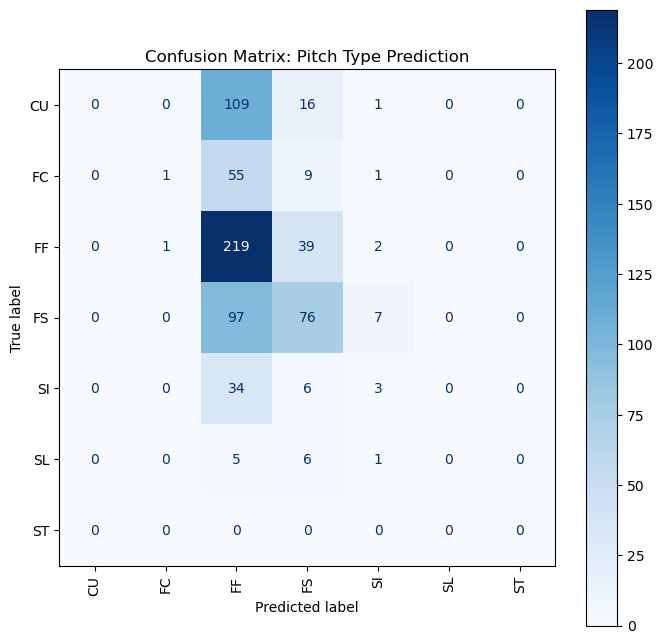

In [18]:
unique_classes = sorted(df["pitch_type_idx"].unique())
class_names = [df[df["pitch_type_idx"]==i]["pitch_type"].iloc[0] for i in unique_classes]

cm = confusion_matrix(all_labels, all_preds, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix: Pitch Type Prediction")
plt.show()


In [19]:
actual_counts = val_df["pitch_type"].value_counts(normalize=True).sort_index()
actual_counts

pitch_type
CU    0.183140
FC    0.095930
FF    0.379360
FS    0.261628
SI    0.062500
SL    0.017442
Name: proportion, dtype: float64

In [20]:
import pandas as pd

pred_series = pd.Series(all_preds)
pred_dist = pred_series.value_counts(normalize=True).sort_index()
pred_dist

1    0.002907
2    0.754360
3    0.220930
4    0.021802
Name: proportion, dtype: float64

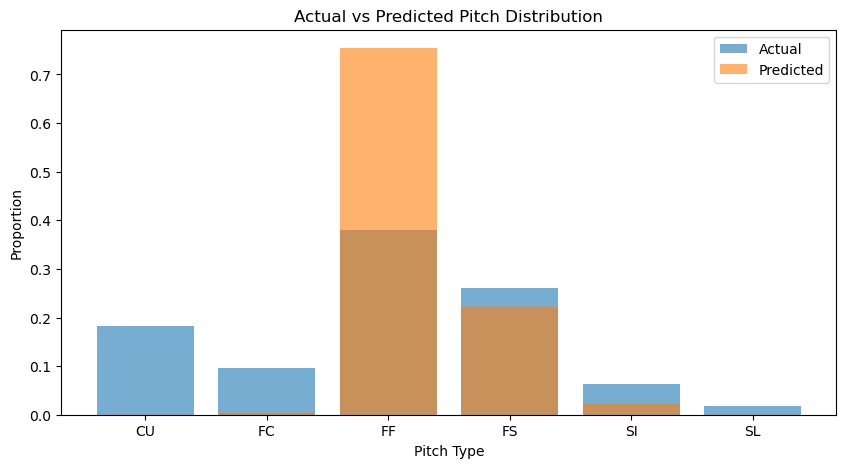

In [21]:
plt.figure(figsize=(10,5))

plt.bar(actual_counts.index, actual_counts.values, alpha=0.6, label="Actual")
plt.bar(pred_dist.index, pred_dist.values, alpha=0.6, label="Predicted")

plt.xlabel("Pitch Type")
plt.ylabel("Proportion")
plt.title("Actual vs Predicted Pitch Distribution")
plt.legend()
plt.show()